## USE TPU

In [ ]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
# hugging face transformers 라이브러리 설치
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 120 kB 67.1 MB/s 
     |████████████████████████████████| 6.6 MB 56.0 MB/s 


## Import library

In [ ]:
import os

import numpy as np
import pandas as pd

from datetime import datetime
import json
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm.notebook import tqdm
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## Download the data

In [ ]:
!gdown 1NmSV5Oaa2UIrSloWEQGgNvRyBRIDYNdA

Downloading...
From: https://drive.google.com/uc?id=1NmSV5Oaa2UIrSloWEQGgNvRyBRIDYNdA
To: /content/kaggledata.pkl
100% 68.6M/68.6M [00:00<00:00, 119MB/s]


In [ ]:
import pickle

with open('/content/kaggledata.pkl', 'rb') as f:
  kg_dataset = pickle.load(f)

## Labeling 16 labels & Check Dataframe

In [ ]:
def label(kg_dataset):
  MBTI = ['INFP', 'ISFP', 'INFJ', 'ISFJ', 'ENFP', 'ESFP', 'ENFJ', 'ESFJ', 'INTP', 'ISTP', 'INTJ', 'ISTJ', 'ENTP', 'ESTP', 'ENTJ', 'ESTJ']
  for idx, mbti in enumerate(MBTI):
    if kg_dataset['type'] == mbti:
      return idx
kg_dataset['label'] = kg_dataset.apply(lambda row: label(row), axis=1)
kg_dataset

,type,posts,I,N,F,P,label
0,INFJ,enfp and intj moments sportscenter not t...,1,1,1,0,2
1,ENTP,im finding the lack of me in these pos...,0,1,0,1,12
2,INTP,good one of course to which i say i ...,1,1,0,1,8
3,INTJ,dear intp i enjoyed our conversation the...,1,1,0,0,10
4,ENTJ,youre fired thats another silly misconcep...,0,1,0,0,14
...,...,...,...,...,...,...,...
8670,ISFP,ixfp just because i always think of cat...,1,0,1,1,1
8671,ENFP,soif this thread already exists someplace...,0,1,1,1,4
8672,INTP,so many questions when i do these thing...,1,1,0,1,8
8673,INFP,i am very conflicted right now when it ...,1,1,1,1,0


In [ ]:
kg_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8675 entries, 0 to 8674
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
 2   I       8675 non-null   int64 
 3   N       8675 non-null   int64 
 4   F       8675 non-null   int64 
 5   P       8675 non-null   int64 
 6   label   8675 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 542.2+ KB


In [ ]:
kg_dataset.dtypes

type     object
posts    object
I         int64
N         int64
F         int64
P         int64
label     int64
dtype: object

In [ ]:
# 결측치 제거
kg_dataset.dropna(inplace=True)

In [ ]:
kg_dataset['label']=pd.to_numeric(kg_dataset['label'])

In [ ]:
kg_dataset['label'].nunique()

16

In [ ]:
kg_dataset['label'].value_counts()

0     1832
2     1470
8     1304
10    1091
12     685
4      675
9      337
1      271
14     231
11     205
6      190
3      166
13      89
5       48
7       42
15      39
Name: label, dtype: int64

## Tokenizer __ encoding

- 한국어 BERT :  https://huggingface.co/snunlp/KR-BERT-char16424

- Fast Tokenizer : https://huggingface.co/docs/transformers/main_classes/tokenizer

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# 인코딩 전 test data의 결측치 제거 
data = kg_dataset.dropna()
print(len(data))

8675


In [ ]:
data= kg_dataset['posts']
target= kg_dataset['label']

In [ ]:
data

0       enfp  and  intj  moments  sportscenter  not  t...
1       im  finding  the  lack  of  me  in  these  pos...
2       good  one    of  course  to  which  i  say  i ...
3       dear  intp  i  enjoyed  our  conversation  the...
4       youre  fired  thats  another  silly  misconcep...
                              ...                        
8670    ixfp  just  because  i  always  think  of  cat...
8671    soif  this  thread  already  exists  someplace...
8672    so  many  questions  when  i  do  these  thing...
8673    i  am  very  conflicted  right  now  when  it ...
8674    it  has  been  too  long  since  i  have  been...
Name: posts, Length: 8675, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=34)

In [ ]:
X_train_list= X_train.tolist()
X_test_list = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

In [ ]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)# truncation : 최대문장 길이에 맞춰서 조정해줌
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [ ]:
print(X_train[12].tokens)

['[CLS]', 'fuck', 'u', 'cum', '##gu', '##zzle', '##r', '##1', 'i', 'was', 'r', '##ly', 'look', '##in', 'forward', 'to', 'gay', '##lord', 'mc', '##bar', '##eb', '##ack', 'crying', 'u', 'pissed', 'birds', '##int', '##ree', '##s', 'off', 'with', 'ur', 'stupid', 'user', '##name', 'requests', 'she', 'should', '##a', 'named', 'u', 'all', 'cum', '##gu', '##zzle', '##r', '##1', '2', '3', 'etc', 'that', 'wasn', '##t', 'fun', 'and', 'games', 'i', 'got', 'my', 'name', 'changed', 'to', 'fa', '##gat', '##ron', '##icus', 'before', 'so', 'i', 'thought', 'gay', '##lord', 'mc', '##bar', '##eb', '##ack', 'was', 'ok', 'is', 'an', '##on', 'per', '##vat', '##hon', 'acceptable', 'sunday', 'is', 'too', 'p', 'to', 'mod', 'per', '##c', 'crush', 'gone', 'terribly', 'wrong', 'it', 'was', 'just', 'a', 'pun', 'not', 'related', 'to', 'topic', 'id', '##io', '##cy', 'not', 'stumbling', 'drunk', 'st', '##aa', '##aa', '##ah', '##p', 'math', '##s', 'is', 'hard', 'haven', '##t', 'u', 'pp', '##l', 'heard', 'of', 'low', '#

In [ ]:
print(X_train[0].ids)

[101, 2339, 2025, 2129, 2079, 3057, 2066, 2000, 2022, 27978, 2098, 2007, 2612, 9826, 2868, 2008, 2003, 2129, 4364, 2323, 27978, 2007, 1037, 2450, 2059, 2360, 2242, 2797, 1037, 8257, 2030, 1037, 7615, 2008, 5942, 2017, 2000, 7204, 1998, 2023, 2003, 2339, 1045, 2333, 2041, 1997, 2026, 4545, 2046, 1037, 2028, 8270, 9954, 2188, 1037, 3542, 2784, 1999, 1996, 5747, 1999, 1996, 2690, 1997, 7880, 14754, 2053, 4067, 2017, 1998, 2115, 2063, 2025, 1037, 11576, 2012, 2035, 6283, 2026, 20810, 8909, 2215, 2000, 2202, 1037, 3357, 2067, 1998, 3198, 2339, 2016, 6732, 2293, 2003, 2069, 2293, 2065, 2009, 16180, 5091, 1999, 2070, 4066, 1997, 8426, 2293, 2003, 8331, 20014, 5654, 7028, 4895, 23947, 4270, 3085, 2017, 2064, 2102, 2360, 1045, 2293, 2017, 3568, 1045, 2293, 2009, 1999, 1996, 5409, 2126, 2049, 2066, 1996, 3819, 14354, 2000, 2033, 2000, 2022, 2409, 1045, 2064, 2102, 2079, 2242, 2030, 2180, 2102, 6162, 2242, 2035, 1997, 2026, 2190, 14152, 2024, 2138, 2619, 2056, 1045, 2481, 2102, 2079, 2009, 1045, 

## Dataset

In [ ]:
import tensorflow as tf

# 주어진 데이터소스를 여러 Tensor로 자른 후 iterator(반복가능 객체)로 만들기
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [ ]:
example = val_dataset.take(1)
a = list(example.as_numpy_iterator())
a

[({'input_ids': array([  101,  4067,  2017,  4166, 10559,  2021,  2009,  3849,  2026,
           2061,  2170,  6898,  2001,  2044,  2035,  1996, 23624, 14289,
          26255,  2785,  1997,  9765,  3501,  2002,  2015,  2042,  3228,
           2033,  1996,  4333,  3949,  2005,  1021,  2420,  2085,  1998,
           1045,  2228,  1996,  3276,  2003,  2058,  4283,  3071,  2005,
           2115,  7928,  2092,  7167,  1997,  2477,  2031,  3047,  2144,
           1045,  2197,  6866,  1045,  2288,  1999,  1037,  3276,  2007,
           2026,  9765,  3501,  2767,  4807,  2001,  2204,  1045,  2113,
           1045,  2071,  2831,  2055,  2505,  1045,  2064,  5293, 10537,
           2505,  9373,  2030,  9569,  2007,  2068,  2036,  2026,  9765,
          22578,  2814,  2024,  2025, 13047,  2000,  2031,  7599,  1997,
          11281,  1045,  2031,  2068,  2035,  1996,  2051,  2026,  9765,
          22578,  2036,  4025,  2000,  5376,  2013,  2092,  2672, 10047,
           2074, 16603,  2477,  1045, 

#### tf.data 데이터셋 생성하기
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices

In [ ]:
# Dataset.from_tensor_slice 예시
dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
list(dataset.as_numpy_iterator())

[array([1, 2], dtype=int32), array([3, 4], dtype=int32)]

In [ ]:
dataset = tf.data.Dataset.range(8)
dataset = dataset.batch(3)
list(dataset.as_numpy_iterator())

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]

- 자주 쓰는 tf.data.dataset 하위 메서드

    -  repeat(n) - Dataset n번 반복해서 하나로 붙힘

    - skip(n) - Dataset 반복자로 돌릴 때 n만큼 skip. n이 7이라면 1~10까지 돌리면 7까지 생략 후 8,9,10 나옴

    - batch(n) - Dataset을 n개의 batch로 쪼갬

    - shuffle(buffer_size, seed=None, reshuffle_each_iteration=None) : dataset을 섞기

## Model


```
{
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0.dev0",
  "vocab_size": 30522
}
```



- model source : https://github.com/huggingface/transformers/blob/v4.19.2/src/transformers/models/bert/modeling_tf_bert.py#L1605

#### 01 Basic


In [ ]:
model_name = " distilbert-base-uncased" 
model = TFDistilBertForSequenceClassification.from_pretrained(model_name,
                                                              num_labels=16)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

with strategy.scope():
  model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                              num_labels=16)
  
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) 
  

  callback_earlystop = EarlyStopping(
      monitor="val_loss", 
      min_delta=0.001,
      patience=3)

  model.fit(
      train_dataset.shuffle(1000).batch(16), epochs=20, batch_size=16,
      validation_data = val_dataset.shuffle(1000).batch(16),callbacks = [callback_earlystop])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_59', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/20
434/434 [==============================] - 90s 85ms/step - loss: 1.9848 - accuracy: 0.3780 - val_loss: 1.6232 - val_accuracy: 0.5170
Epoch 2/20
434/434 [==============================] - 30s 70ms/step - loss: 1.4816 - accuracy: 0.5657 - val_loss: 1.4463 - val_accuracy: 0.5781
Epoch 3/20
434/434 [==============================] - 30s 69ms/step - loss: 1.2126 - accuracy: 0.6427 - val_loss: 1.4564 - val_accuracy: 0.5764
Epoch 4/20
434/434 [==============================] - 30s 69ms/step - loss: 0.9231 - accuracy: 0.7356 - val_loss: 1.4986 - val_accuracy: 0.5729
Epoch 5/20
434/434 [==============================] - 30s 69ms/step - loss: 0.6282 - accuracy: 0.8256 - val_loss: 1.6528 - val_accuracy: 0.5752


In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  12304     
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66,965,776
Trainable params: 66,965,776
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save_weights("distilbert-base-uncased.h5")

#### 02 Dropout

##### 1) Dropout

In [ ]:
label2id = {
    'INFP' : 0, 
    'ISFP' : 1, 
    'INFJ' : 2, 
    'ISFJ' : 3, 
    'ENFP' : 4, 
    'ESFP' : 5, 
    'ENFJ' : 6, 
    'ESFJ' : 7, 
    'INTP' : 8, 
    'ISTP' : 9, 
    'INTJ' : 10, 
    'ISTJ' : 11, 
    'ENTP' : 12, 
    'ESTP' : 13, 
    'ENTJ' : 14, 
    'ESTJ' : 15
}

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig

pretrained_model_name = "distilbert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)

id2label = {y:x for x,y in label2id.items()}
config.label2id = label2id
config.id2label = id2label
config.dropout = 0.5
# config._num_labels = len(label2id)


In [ ]:

config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.5,
  "hidden_dim": 3072,
  "id2label": {
    "0": "INFP",
    "1": "ISFP",
    "2": "INFJ",
    "3": "ISFJ",
    "4": "ENFP",
    "5": "ESFP",
    "6": "ENFJ",
    "7": "ESFJ",
    "8": "INTP",
    "9": "ISTP",
    "10": "INTJ",
    "11": "ISTJ",
    "12": "ENTP",
    "13": "ESTP",
    "14": "ENTJ",
    "15": "ESTJ"
  },
  "initializer_range": 0.02,
  "label2id": {
    "ENFJ": 6,
    "ENFP": 4,
    "ENTJ": 14,
    "ENTP": 12,
    "ESFJ": 7,
    "ESFP": 5,
    "ESTJ": 15,
    "ESTP": 13,
    "INFJ": 2,
    "INFP": 0,
    "INTJ": 10,
    "INTP": 8,
    "ISFJ": 3,
    "ISFP": 1,
    "ISTJ": 11,
    "ISTP": 9
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoida

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

with strategy.scope():
  model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, config=config, ignore_mismatched_sizes=True)


  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # 이진분류 
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


  callback_earlystop = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.001,
    patience=5)

  model.fit(
    train_dataset.shuffle(1000).batch(16), epochs=20, batch_size=16,
    validation_data = val_dataset.shuffle(1000).batch(16),callbacks = [callback_earlystop])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_179', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/20
434/434 [==============================] - 93s 88ms/step - loss: 2.3058 - accuracy: 0.2046 - val_loss: 2.2242 - val_accuracy: 0.2576
Epoch 2/20
434/434 [==============================] - 31s 71ms/step - loss: 2.1539 - accuracy: 0.2761 - val_loss: 2.1442 - val_accuracy: 0.2865
Epoch 3/20
434/434 [==============================] - 31s 71ms/step - loss: 1.9537 - accuracy: 0.3532 - val_loss: 2.0116 - val_accuracy: 0.4006
Epoch 4/20
434/434 [==============================] - 31s 71ms/step - loss: 1.7274 - accuracy: 0.4408 - val_loss: 1.9019 - val_accuracy: 0.4190
Epoch 5/20
434/434 [==============================] - 31s 71ms/step - loss: 1.5319 - accuracy: 0.4935 - val_loss: 1.8474 - val_accuracy: 0.4519
Epoch 6/20
434/434 [==============================] - 32s 74ms/step - loss: 1.3798 - accuracy: 0.5367 - val_loss: 1.9086 - val_accuracy: 0.4461
Epoch 7/20
434/434 [==============================] - 31s 72ms/step - loss: 1.2271 - accuracy: 0.5955 - val_loss: 1.8040 - val_accuracy:

##### 2) Attention_dropout

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig

pretrained_model_name = "distilbert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)


id2label = {y:x for x,y in label2id.items()}
config.label2id = label2id
config.id2label = id2label
config.dropout = 0.5
config.attention_dropout = 0.5

In [ ]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.5,
  "dim": 768,
  "dropout": 0.5,
  "hidden_dim": 3072,
  "id2label": {
    "0": "INFP",
    "1": "ISFP",
    "2": "INFJ",
    "3": "ISFJ",
    "4": "ENFP",
    "5": "ESFP",
    "6": "ENFJ",
    "7": "ESFJ",
    "8": "INTP",
    "9": "ISTP",
    "10": "INTJ",
    "11": "ISTJ",
    "12": "ENTP",
    "13": "ESTP",
    "14": "ENTJ",
    "15": "ESTJ"
  },
  "initializer_range": 0.02,
  "label2id": {
    "ENFJ": 6,
    "ENFP": 4,
    "ENTJ": 14,
    "ENTP": 12,
    "ESFJ": 7,
    "ESFP": 5,
    "ESTJ": 15,
    "ESTP": 13,
    "INFJ": 2,
    "INFP": 0,
    "INTJ": 10,
    "INTP": 8,
    "ISFJ": 3,
    "ISFP": 1,
    "ISTJ": 11,
    "ISTP": 9
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoida

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

with strategy.scope():
  model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, config=config, ignore_mismatched_sizes=True)


  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # 이진분류 
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


  callback_earlystop = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.001,
    patience=5)

  model.fit(
    train_dataset.shuffle(1000).batch(16), epochs=20, batch_size=16,
    validation_data = val_dataset.shuffle(1000).batch(16),callbacks = [callback_earlystop])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_199', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/20
434/434 [==============================] - 92s 92ms/step - loss: 2.2952 - accuracy: 0.2104 - val_loss: 2.2117 - val_accuracy: 0.2599
Epoch 2/20
434/434 [==============================] - 31s 71ms/step - loss: 2.1106 - accuracy: 0.2932 - val_loss: 2.0794 - val_accuracy: 0.2882
Epoch 3/20
434/434 [==============================] - 31s 71ms/step - loss: 1.9671 - accuracy: 0.3414 - val_loss: 1.9208 - val_accuracy: 0.3908
Epoch 4/20
434/434 [==============================] - 30s 70ms/step - loss: 1.7175 - accuracy: 0.4324 - val_loss: 1.8190 - val_accuracy: 0.4409
Epoch 5/20
434/434 [==============================] - 30s 70ms/step - loss: 1.5049 - accuracy: 0.5069 - val_loss: 1.9185 - val_accuracy: 0.4605
Epoch 6/20
434/434 [==============================] - 30s 70ms/step - loss: 1.3581 - accuracy: 0.5683 - val_loss: 1.9871 - val_accuracy: 0.4726
Epoch 7/20
434/434 [==============================] - 30s 70ms/step - loss: 1.1878 - accuracy: 0.6226 - val_loss: 2.0619 - val_accuracy:

##### 3) qa_dropout

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig

pretrained_model_name = "distilbert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)

id2label = {y:x for x,y in label2id.items()}
config.label2id = label2id
config.id2label = id2label
config.dropout = 0.5
config.attention_dropout = 0.5
config.qa_dropout = 0.2




In [ ]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.5,
  "dim": 768,
  "dropout": 0.5,
  "hidden_dim": 3072,
  "id2label": {
    "0": "INFP",
    "1": "ISFP",
    "2": "INFJ",
    "3": "ISFJ",
    "4": "ENFP",
    "5": "ESFP",
    "6": "ENFJ",
    "7": "ESFJ",
    "8": "INTP",
    "9": "ISTP",
    "10": "INTJ",
    "11": "ISTJ",
    "12": "ENTP",
    "13": "ESTP",
    "14": "ENTJ",
    "15": "ESTJ"
  },
  "initializer_range": 0.02,
  "label2id": {
    "ENFJ": 6,
    "ENFP": 4,
    "ENTJ": 14,
    "ENTP": 12,
    "ESFJ": 7,
    "ESFP": 5,
    "ESTJ": 15,
    "ESTP": 13,
    "INFJ": 2,
    "INFP": 0,
    "INTJ": 10,
    "INTP": 8,
    "ISFJ": 3,
    "ISFP": 1,
    "ISTJ": 11,
    "ISTP": 9
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.2,
  "seq_classif_dropout": 0.2,
  "sinusoida

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

with strategy.scope():
  model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, config=config, ignore_mismatched_sizes=True)


  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # 이진분류 
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


  callback_earlystop = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.001,
    patience=5)

  model.fit(
    train_dataset.shuffle(1000).batch(16), epochs=20, batch_size=16,
    validation_data = val_dataset.shuffle(1000).batch(16),callbacks = [callback_earlystop])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_239', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/20
434/434 [==============================] - 92s 90ms/step - loss: 2.2955 - accuracy: 0.2130 - val_loss: 2.2036 - val_accuracy: 0.2686
Epoch 2/20
434/434 [==============================] - 31s 71ms/step - loss: 2.0676 - accuracy: 0.3045 - val_loss: 1.9628 - val_accuracy: 0.3550
Epoch 3/20
434/434 [==============================] - 31s 70ms/step - loss: 1.8032 - accuracy: 0.4180 - val_loss: 1.8030 - val_accuracy: 0.4156
Epoch 4/20
434/434 [==============================] - 30s 70ms/step - loss: 1.6100 - accuracy: 0.4790 - val_loss: 1.7346 - val_accuracy: 0.4801
Epoch 5/20
434/434 [==============================] - 30s 70ms/step - loss: 1.4398 - accuracy: 0.5467 - val_loss: 1.7272 - val_accuracy: 0.4888
Epoch 6/20
434/434 [==============================] - 31s 71ms/step - loss: 1.2989 - accuracy: 0.5908 - val_loss: 1.7507 - val_accuracy: 0.4911
Epoch 7/20
434/434 [==============================] - 30s 70ms/step - loss: 1.1465 - accuracy: 0.6427 - val_loss: 1.8788 - val_accuracy:

##### 4)Seq_classif_dropout

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig

pretrained_model_name = "distilbert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)

id2label = {y:x for x,y in label2id.items()}
config.label2id = label2id
config.id2label = id2label
config.dropout = 0.1
config.attention_dropout = 0.1
config.qa_dropout = 0.1
config.seq_classif_dropout = 0.1



In [ ]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "INFP",
    "1": "ISFP",
    "2": "INFJ",
    "3": "ISFJ",
    "4": "ENFP",
    "5": "ESFP",
    "6": "ENFJ",
    "7": "ESFJ",
    "8": "INTP",
    "9": "ISTP",
    "10": "INTJ",
    "11": "ISTJ",
    "12": "ENTP",
    "13": "ESTP",
    "14": "ENTJ",
    "15": "ESTJ"
  },
  "initializer_range": 0.02,
  "label2id": {
    "ENFJ": 6,
    "ENFP": 4,
    "ENTJ": 14,
    "ENTP": 12,
    "ESFJ": 7,
    "ESFP": 5,
    "ESTJ": 15,
    "ESTP": 13,
    "INFJ": 2,
    "INFP": 0,
    "INTJ": 10,
    "INTP": 8,
    "ISFJ": 3,
    "ISFP": 1,
    "ISTJ": 11,
    "ISTP": 9
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.1,
  "sinusoida

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

with strategy.scope():
  model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, config=config, ignore_mismatched_sizes=True)


  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # 이진분류 
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


  callback_earlystop = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.001,
    patience=5)

  model.fit(
    train_dataset.shuffle(5000).batch(16), epochs=20, batch_size=16,
    validation_data = val_dataset.shuffle(5000).batch(16),callbacks = [callback_earlystop])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_399', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/20
434/434 [==============================] - 92s 87ms/step - loss: 1.8192 - accuracy: 0.4460 - val_loss: 1.4950 - val_accuracy: 0.5602
Epoch 2/20
434/434 [==============================] - 30s 70ms/step - loss: 1.3596 - accuracy: 0.5955 - val_loss: 1.3695 - val_accuracy: 0.5994
Epoch 3/20
434/434 [==============================] - 31s 70ms/step - loss: 1.0551 - accuracy: 0.6945 - val_loss: 1.3815 - val_accuracy: 0.6104
Epoch 4/20
434/434 [==============================] - 31s 71ms/step - loss: 0.7932 - accuracy: 0.7754 - val_loss: 1.5270 - val_accuracy: 0.5942
Epoch 5/20
434/434 [==============================] - 30s 70ms/step - loss: 0.5309 - accuracy: 0.8546 - val_loss: 1.6747 - val_accuracy: 0.5983
Epoch 6/20
434/434 [==============================] - 31s 71ms/step - loss: 0.3557 - accuracy: 0.9071 - val_loss: 1.8641 - val_accuracy: 0.5965
Epoch 7/20
434/434 [==============================] - 31s 70ms/step - loss: 0.2576 - accuracy: 0.9327 - val_loss: 1.9684 - val_accuracy:

In [ ]:
model.save_weights("distilbert-base-uncased_16_0.1_5000.h5")

## Test

In [ ]:
# output을 바로 뽑아주는 TextClassificationPipeline
from transformers import TextClassificationPipeline

# 로드하기
# loaded_tokenizer = BertTokenizerFast.from_pretrained('nsmc_model/bert-base')
# loaded_model =  TFBertForSequenceClassification.from_pretrained('nsmc_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=tokenizer, 
    model=model, 
    framework='tf',
    return_all_scores=True
)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [ ]:
# 라벨과 score 이 나온다I
text_classifier("Let’s think the unthinkable, let’s do the undoable. Let us prepare to grapple with the ineffable itself, and see if we may not eff it after all.")[0]

[{'label': 'INFP', 'score': 0.0010914737358689308},
 {'label': 'ISFP', 'score': 0.0001653196959523484},
 {'label': 'INFJ', 'score': 0.9951488375663757},
 {'label': 'ISFJ', 'score': 0.0001227335014846176},
 {'label': 'ENFP', 'score': 0.0003621676005423069},
 {'label': 'ESFP', 'score': 1.806698855943978e-05},
 {'label': 'ENFJ', 'score': 0.0003772991185542196},
 {'label': 'ESFJ', 'score': 0.0001294520334340632},
 {'label': 'INTP', 'score': 0.0011161565780639648},
 {'label': 'ISTP', 'score': 4.6373079385375604e-05},
 {'label': 'INTJ', 'score': 0.000525577284861356},
 {'label': 'ISTJ', 'score': 0.00029449057183228433},
 {'label': 'ENTP', 'score': 0.00031950007542036474},
 {'label': 'ESTP', 'score': 0.00014522364654112607},
 {'label': 'ENTJ', 'score': 0.00010467090760357678},
 {'label': 'ESTJ', 'score': 3.27136876876466e-05}]

In [ ]:
text_classifier("	You look pretty hot. I like!")

[[{'label': 'INFP', 'score': 0.06309282779693604},
  {'label': 'ISFP', 'score': 0.09868641197681427},
  {'label': 'INFJ', 'score': 0.10263273119926453},
  {'label': 'ISFJ', 'score': 0.15458598732948303},
  {'label': 'ENFP', 'score': 0.07133836299180984},
  {'label': 'ESFP', 'score': 0.021062450483441353},
  {'label': 'ENFJ', 'score': 0.010531352832913399},
  {'label': 'ESFJ', 'score': 0.017437608912587166},
  {'label': 'INTP', 'score': 0.17384864389896393},
  {'label': 'ISTP', 'score': 0.05745426192879677},
  {'label': 'INTJ', 'score': 0.03397715836763382},
  {'label': 'ISTJ', 'score': 0.11109961569309235},
  {'label': 'ENTP', 'score': 0.04810304194688797},
  {'label': 'ESTP', 'score': 0.012889859266579151},
  {'label': 'ENTJ', 'score': 0.014600727707147598},
  {'label': 'ESTJ', 'score': 0.008659040555357933}]]

In [ ]:
text_classifier("Many personality.")[0]

[{'label': 'INFP', 'score': 0.09689627587795258},
 {'label': 'ISFP', 'score': 0.10191259533166885},
 {'label': 'INFJ', 'score': 0.5548394322395325},
 {'label': 'ISFJ', 'score': 0.08911202847957611},
 {'label': 'ENFP', 'score': 0.03613169863820076},
 {'label': 'ESFP', 'score': 0.00702262856066227},
 {'label': 'ENFJ', 'score': 0.00958835706114769},
 {'label': 'ESFJ', 'score': 0.014525262638926506},
 {'label': 'INTP', 'score': 0.026390880346298218},
 {'label': 'ISTP', 'score': 0.008344756439328194},
 {'label': 'INTJ', 'score': 0.008578008972108364},
 {'label': 'ISTJ', 'score': 0.022552508860826492},
 {'label': 'ENTP', 'score': 0.011391929350793362},
 {'label': 'ESTP', 'score': 0.005815360229462385},
 {'label': 'ENTJ', 'score': 0.0028084071818739176},
 {'label': 'ESTJ', 'score': 0.004089892841875553}]

In [ ]:
text_classifier("I had a conversation with my roommate and I got so frustrated")[0]

[{'label': 'INFP', 'score': 0.07944352924823761},
 {'label': 'ISFP', 'score': 0.04330607131123543},
 {'label': 'INFJ', 'score': 0.07850050926208496},
 {'label': 'ISFJ', 'score': 0.10404197871685028},
 {'label': 'ENFP', 'score': 0.06038493663072586},
 {'label': 'ESFP', 'score': 0.034683044999837875},
 {'label': 'ENFJ', 'score': 0.031832072883844376},
 {'label': 'ESFJ', 'score': 0.03384586051106453},
 {'label': 'INTP', 'score': 0.12483781576156616},
 {'label': 'ISTP', 'score': 0.08036894351243973},
 {'label': 'INTJ', 'score': 0.06392821669578552},
 {'label': 'ISTJ', 'score': 0.08645940572023392},
 {'label': 'ENTP', 'score': 0.06852173060178757},
 {'label': 'ESTP', 'score': 0.03281177952885628},
 {'label': 'ENTJ', 'score': 0.04882591590285301},
 {'label': 'ESTJ', 'score': 0.028208106756210327}]

In [ ]:
text_classifier("Let’s think the unthinkable, let’s do the undoable. Let us prepare to grapple with the ineffable itself, and see if we may not eff it after all.")[0]

[{'label': 'INFP', 'score': 0.0010914737358689308},
 {'label': 'ISFP', 'score': 0.0001653196959523484},
 {'label': 'INFJ', 'score': 0.9951488375663757},
 {'label': 'ISFJ', 'score': 0.0001227335014846176},
 {'label': 'ENFP', 'score': 0.0003621676005423069},
 {'label': 'ESFP', 'score': 1.806698855943978e-05},
 {'label': 'ENFJ', 'score': 0.0003772991185542196},
 {'label': 'ESFJ', 'score': 0.0001294520334340632},
 {'label': 'INTP', 'score': 0.0011161565780639648},
 {'label': 'ISTP', 'score': 4.6373079385375604e-05},
 {'label': 'INTJ', 'score': 0.000525577284861356},
 {'label': 'ISTJ', 'score': 0.00029449057183228433},
 {'label': 'ENTP', 'score': 0.00031950007542036474},
 {'label': 'ESTP', 'score': 0.00014522364654112607},
 {'label': 'ENTJ', 'score': 0.00010467090760357678},
 {'label': 'ESTJ', 'score': 3.27136876876466e-05}]

In [ ]:
text_classifier("I don’t really want to become normal, average, standard. I want merely to gain in strength, in the courage to live out my life more fully, enjoy more, experience more. I want to develop even more original and more unconventional traits")[0]


[{'label': 'INFP', 'score': 0.02550782449543476},
 {'label': 'ISFP', 'score': 0.02820185199379921},
 {'label': 'INFJ', 'score': 0.2030164897441864},
 {'label': 'ISFJ', 'score': 0.0646274983882904},
 {'label': 'ENFP', 'score': 0.20036597549915314},
 {'label': 'ESFP', 'score': 0.03562111034989357},
 {'label': 'ENFJ', 'score': 0.10324183106422424},
 {'label': 'ESFJ', 'score': 0.034407008439302444},
 {'label': 'INTP', 'score': 0.05932029336690903},
 {'label': 'ISTP', 'score': 0.02964046783745289},
 {'label': 'INTJ', 'score': 0.06633510440587997},
 {'label': 'ISTJ', 'score': 0.03466780111193657},
 {'label': 'ENTP', 'score': 0.05640110746026039},
 {'label': 'ESTP', 'score': 0.021498873829841614},
 {'label': 'ENTJ', 'score': 0.017558014020323753},
 {'label': 'ESTJ', 'score': 0.01958877593278885}]

In [ ]:
# INTP -- 2/4 (INFJ)
text_classifier('Remind me ! 40 hours')

[[{'label': 'INFP', 'score': 0.0187872014939785},
  {'label': 'ISFP', 'score': 0.03369605913758278},
  {'label': 'INFJ', 'score': 0.30793923139572144},
  {'label': 'ISFJ', 'score': 0.08254878968000412},
  {'label': 'ENFP', 'score': 0.022642850875854492},
  {'label': 'ESFP', 'score': 0.009011059999465942},
  {'label': 'ENFJ', 'score': 0.011542556807398796},
  {'label': 'ESFJ', 'score': 0.011094622313976288},
  {'label': 'INTP', 'score': 0.19039008021354675},
  {'label': 'ISTP', 'score': 0.11174629628658295},
  {'label': 'INTJ', 'score': 0.033398762345314026},
  {'label': 'ISTJ', 'score': 0.06365199387073517},
  {'label': 'ENTP', 'score': 0.05660947412252426},
  {'label': 'ESTP', 'score': 0.03469965606927872},
  {'label': 'ENTJ', 'score': 0.008136452175676823},
  {'label': 'ESTJ', 'score': 0.004104895051568747}]]

In [ ]:
# INTP -- OK
text_classifier("""Definitely, within what I suppose you could call 'genetic reasoning'.

"He has his mother's eyes" is a well known trope in baby analysis.

"He has his mother's brain" is exactly the same type of statement.""")

[[{'label': 'INFP', 'score': 0.0035601193085312843},
  {'label': 'ISFP', 'score': 0.0013497361214831471},
  {'label': 'INFJ', 'score': 0.03619542345404625},
  {'label': 'ISFJ', 'score': 0.0044404854997992516},
  {'label': 'ENFP', 'score': 0.007083394564688206},
  {'label': 'ESFP', 'score': 0.002383410930633545},
  {'label': 'ENFJ', 'score': 0.00409498019143939},
  {'label': 'ESFJ', 'score': 0.0031805739272385836},
  {'label': 'INTP', 'score': 0.6813070178031921},
  {'label': 'ISTP', 'score': 0.01097847893834114},
  {'label': 'INTJ', 'score': 0.12301351875066757},
  {'label': 'ISTJ', 'score': 0.005717647727578878},
  {'label': 'ENTP', 'score': 0.0995500236749649},
  {'label': 'ESTP', 'score': 0.0027946962509304285},
  {'label': 'ENTJ', 'score': 0.013253813609480858},
  {'label': 'ESTJ', 'score': 0.0010966836707666516}]]

In [ ]:
#ISTP -- 3/4 (ISTJ)
text_classifier("""I would be screwed as an experienced software engineer because the hiring company would filter for NTs. In fact, I was filtered out once after taking a personality assessment. Not MBTI, think it was the color code test. I came out as a red and was told that there was a concern that I would "ask too many questions" They probably did me a favor.""")

[[{'label': 'INFP', 'score': 0.07234083116054535},
  {'label': 'ISFP', 'score': 0.0173890832811594},
  {'label': 'INFJ', 'score': 0.0030634289141744375},
  {'label': 'ISFJ', 'score': 0.021328631788492203},
  {'label': 'ENFP', 'score': 0.015497218817472458},
  {'label': 'ESFP', 'score': 0.007667909376323223},
  {'label': 'ENFJ', 'score': 0.003827720182016492},
  {'label': 'ESFJ', 'score': 0.004168214742094278},
  {'label': 'INTP', 'score': 0.30137383937835693},
  {'label': 'ISTP', 'score': 0.09154156595468521},
  {'label': 'INTJ', 'score': 0.05901547148823738},
  {'label': 'ISTJ', 'score': 0.32924431562423706},
  {'label': 'ENTP', 'score': 0.016923952847719193},
  {'label': 'ESTP', 'score': 0.00576335983350873},
  {'label': 'ENTJ', 'score': 0.03706660494208336},
  {'label': 'ESTJ', 'score': 0.013787792064249516}]]

In [ ]:
#INFP
text_classifier("I do agree that it'd be best to look into each type which can help you determine.")

[[{'label': 'INFP', 'score': 0.0561041533946991},
  {'label': 'ISFP', 'score': 0.11892961710691452},
  {'label': 'INFJ', 'score': 0.07903682440519333},
  {'label': 'ISFJ', 'score': 0.2163628190755844},
  {'label': 'ENFP', 'score': 0.14443400502204895},
  {'label': 'ESFP', 'score': 0.045101698487997055},
  {'label': 'ENFJ', 'score': 0.044634971767663956},
  {'label': 'ESFJ', 'score': 0.03934035077691078},
  {'label': 'INTP', 'score': 0.03860582038760185},
  {'label': 'ISTP', 'score': 0.021532731130719185},
  {'label': 'INTJ', 'score': 0.02424246445298195},
  {'label': 'ISTJ', 'score': 0.10134968906641006},
  {'label': 'ENTP', 'score': 0.021563194692134857},
  {'label': 'ESTP', 'score': 0.012644805945456028},
  {'label': 'ENTJ', 'score': 0.012014379724860191},
  {'label': 'ESTJ', 'score': 0.0241024661809206}]]

In [ ]:
#ENFP
text_classifier("""I think exclusion of type is quite shallow. Everyone has the opportunity to develop skills in any area and I wouldn't work for a boss who overlooks other types when there may be ISTJs more talented than me. I wouldn't work for someone so closed-minded, even if they had excellent intuition because they don't share my values and I know at least one person from all the 16 personality types who share my values.""")

[[{'label': 'INFP', 'score': 0.018948564305901527},
  {'label': 'ISFP', 'score': 0.0021077939309179783},
  {'label': 'INFJ', 'score': 0.00574389286339283},
  {'label': 'ISFJ', 'score': 0.007337221875786781},
  {'label': 'ENFP', 'score': 0.005456213839352131},
  {'label': 'ESFP', 'score': 0.0004286954354029149},
  {'label': 'ENFJ', 'score': 0.0035136498045176268},
  {'label': 'ESFJ', 'score': 0.0007933896267786622},
  {'label': 'INTP', 'score': 0.005538288038223982},
  {'label': 'ISTP', 'score': 0.0033418722450733185},
  {'label': 'INTJ', 'score': 0.004432294983416796},
  {'label': 'ISTJ', 'score': 0.9343432784080505},
  {'label': 'ENTP', 'score': 0.0006217090995050967},
  {'label': 'ESTP', 'score': 0.000915205164346844},
  {'label': 'ENTJ', 'score': 0.0008033771300688386},
  {'label': 'ESTJ', 'score': 0.005674549378454685}]]

In [ ]:
#ESTJ
text_classifier(""""hope he has not been with another woman and I would recommend that you forgive him for his weakness and realize that, if he was your first and if you were his..."

LOL if he cheated on her she needs to pull her britches up and leave him.""")

[[{'label': 'INFP', 'score': 0.06536965072154999},
  {'label': 'ISFP', 'score': 0.03285572677850723},
  {'label': 'INFJ', 'score': 0.5923211574554443},
  {'label': 'ISFJ', 'score': 0.03317048400640488},
  {'label': 'ENFP', 'score': 0.08594411611557007},
  {'label': 'ESFP', 'score': 0.00822379533201456},
  {'label': 'ENFJ', 'score': 0.02975614368915558},
  {'label': 'ESFJ', 'score': 0.01657826639711857},
  {'label': 'INTP', 'score': 0.035010043531656265},
  {'label': 'ISTP', 'score': 0.01052255928516388},
  {'label': 'INTJ', 'score': 0.01984895020723343},
  {'label': 'ISTJ', 'score': 0.0277454424649477},
  {'label': 'ENTP', 'score': 0.017738057300448418},
  {'label': 'ESTP', 'score': 0.008534497581422329},
  {'label': 'ENTJ', 'score': 0.008221595548093319},
  {'label': 'ESTJ', 'score': 0.008159591816365719}]]

In [ ]:
#ENTJ
text_classifier("True, it's best for her to focus on herself, not wandering around social medias.")

[[{'label': 'INFP', 'score': 0.35399240255355835},
  {'label': 'ISFP', 'score': 0.1367618590593338},
  {'label': 'INFJ', 'score': 0.2045169174671173},
  {'label': 'ISFJ', 'score': 0.13459911942481995},
  {'label': 'ENFP', 'score': 0.053621042519807816},
  {'label': 'ESFP', 'score': 0.007034676615148783},
  {'label': 'ENFJ', 'score': 0.012333390302956104},
  {'label': 'ESFJ', 'score': 0.012590699829161167},
  {'label': 'INTP', 'score': 0.02537243813276291},
  {'label': 'ISTP', 'score': 0.009759682230651379},
  {'label': 'INTJ', 'score': 0.007384187541902065},
  {'label': 'ISTJ', 'score': 0.01986677572131157},
  {'label': 'ENTP', 'score': 0.007047613617032766},
  {'label': 'ESTP', 'score': 0.0040753246285021305},
  {'label': 'ENTJ', 'score': 0.005456550512462854},
  {'label': 'ESTJ', 'score': 0.0055872779339551926}]]

In [ ]:
#ENTJ
text_classifier("Something practical, simple in predominantly black colors. Minimal effort and universality.")

[[{'label': 'INFP', 'score': 0.043784625828266144},
  {'label': 'ISFP', 'score': 0.03488916531205177},
  {'label': 'INFJ', 'score': 0.6506757736206055},
  {'label': 'ISFJ', 'score': 0.017761727795004845},
  {'label': 'ENFP', 'score': 0.0034165503457188606},
  {'label': 'ESFP', 'score': 0.001450770883820951},
  {'label': 'ENFJ', 'score': 0.006164053454995155},
  {'label': 'ESFJ', 'score': 0.008419811725616455},
  {'label': 'INTP', 'score': 0.20679360628128052},
  {'label': 'ISTP', 'score': 0.0059026507660746574},
  {'label': 'INTJ', 'score': 0.003922239411622286},
  {'label': 'ISTJ', 'score': 0.004880200605839491},
  {'label': 'ENTP', 'score': 0.005030260421335697},
  {'label': 'ESTP', 'score': 0.004134078975766897},
  {'label': 'ENTJ', 'score': 0.0018646545941010118},
  {'label': 'ESTJ', 'score': 0.0009098718292079866}]]

In [ ]:
#ENFP
text_classifier("""I get to dress as I like since retiring from the corporate world. I favor loose, flowing layers in earth or jewel tones, often overlaying black, cool greys, or the occasional brown. I wear a lot of boho skirts or maxi dresses, and dusters with ankle or knee high boots. If I wear pants (to the gym, or on colder days), I usually choose soft fabrics with flared legs or leggings that tuck into my boots.""")

[[{'label': 'INFP', 'score': 0.04583830013871193},
  {'label': 'ISFP', 'score': 0.008484907448291779},
  {'label': 'INFJ', 'score': 0.12391895055770874},
  {'label': 'ISFJ', 'score': 0.0028562878724187613},
  {'label': 'ENFP', 'score': 0.004254872445017099},
  {'label': 'ESFP', 'score': 0.0010164730483666062},
  {'label': 'ENFJ', 'score': 0.0018109317170456052},
  {'label': 'ESFJ', 'score': 0.0012566905934363604},
  {'label': 'INTP', 'score': 0.4847601652145386},
  {'label': 'ISTP', 'score': 0.25536882877349854},
  {'label': 'INTJ', 'score': 0.03664635866880417},
  {'label': 'ISTJ', 'score': 0.0035520337987691164},
  {'label': 'ENTP', 'score': 0.0223517045378685},
  {'label': 'ESTP', 'score': 0.005100425332784653},
  {'label': 'ENTJ', 'score': 0.0023598605766892433},
  {'label': 'ESTJ', 'score': 0.0004231670463923365}]]

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

#Predict
y_pred = model.predict(X_test['input_ids'])

In [ ]:
y_pred_arg = np.argmax(y_pred['logits'], axis=1)

In [ ]:
label = ['INFP', 'ISFP', 'INFJ', 'ISFJ', 'ENFP', 'ESFP', 'ENFJ', 'ESFJ', 'INTP', 'ISTP', 'INTJ', 'ISTJ', 'ENTP', 'ESTP', 'ENTJ', 'ESTJ']


In [ ]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_arg)

print(cf_matrix)

[[187  13  41   3  30   2   6   0  27   8  20   7  14   1   7   0]
 [  6  31   4   0   3   2   1   0   0   2   1   2   1   0   1   0]
 [ 22   1 191   2  14   1   9   0  21   7  10   2  12   1   1   0]
 [  1   0   0  22   2   0   0   1   2   0   1   0   3   0   1   0]
 [  2   2  10   2  76   0   5   1   8   2   8   6  10   1   2   0]
 [  3   1   0   0   2   1   0   0   0   0   2   1   0   0   0   0]
 [  3   1   2   0   4   0  20   0   3   0   2   1   2   0   0   0]
 [  0   0   0   2   0   0   1   5   0   0   0   0   0   0   1   0]
 [  9   4  13   2  10   0   1   3 151   7  16   2  33   3   7   0]
 [  1   0   1   1   3   0   1   0   4  45   2   2   4   2   1   0]
 [  6   2  15   1  11   1   1   1  30   4 112   2  19   4   9   0]
 [  2   2   0   0   3   0   0   0   4   4   3  20   2   0   1   0]
 [  1   2   4   4   9   0   1   0  16   4  10   3  79   0   4   0]
 [  0   0   1   0   1   0   1   0   1   1   1   0   0  10   2   0]
 [  2   2   1   0   1   0   1   0   2   1   1   1   4   1  29 

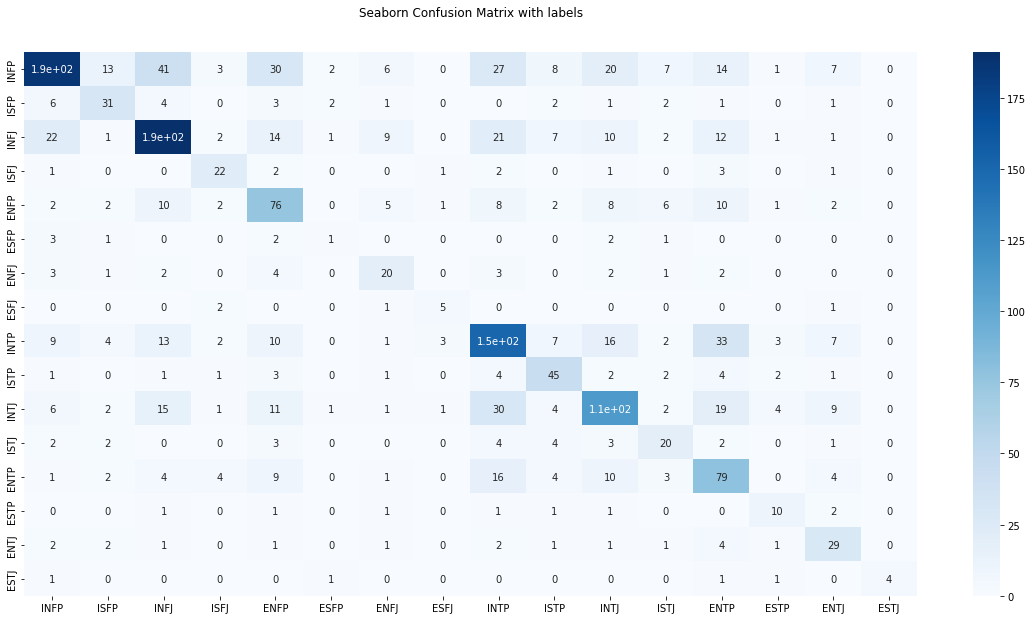

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
# ax.set_xlabel('\nPredicted Flower Category')
# ax.set_ylabel('Actual Flower Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label)
ax.yaxis.set_ticklabels(label)

## Display the visualization of the Confusion Matrix.
plt.show()

## Word cloud


In [ ]:
data   # data = dataset['posts']

0       enfp  and  intj  moments  sportscenter  not  t...
1       im  finding  the  lack  of  me  in  these  pos...
2       good  one    of  course  to  which  i  say  i ...
3       dear  intp  i  enjoyed  our  conversation  the...
4       youre  fired  thats  another  silly  misconcep...
                              ...                        
8670    ixfp  just  because  i  always  think  of  cat...
8671    soif  this  thread  already  exists  someplace...
8672    so  many  questions  when  i  do  these  thing...
8673    i  am  very  conflicted  right  now  when  it ...
8674    it  has  been  too  long  since  i  have  been...
Name: posts, Length: 8675, dtype: object

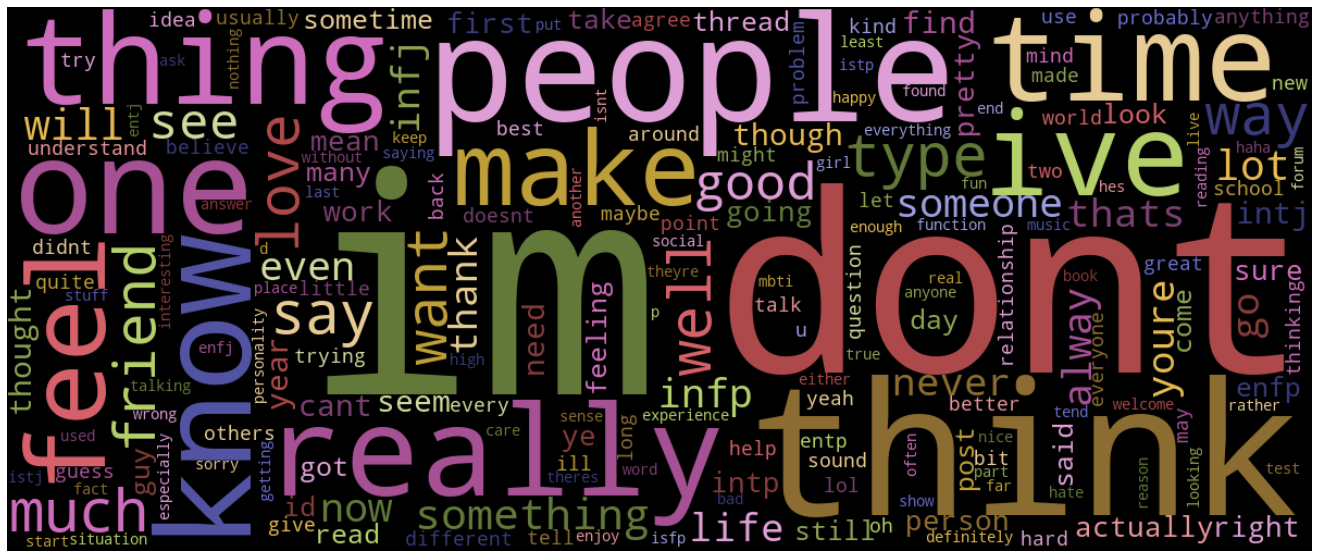

In [ ]:
#Wordcloud - see most common words used, after removing stopwords
from wordcloud import WordCloud, STOPWORDS
#stopwords = common english words that don't add significant value to prediction/analysis eg: I, was, who, some, why etc
import matplotlib.pyplot as plt

words = list(data.apply(lambda x: x.split()))
words = [x for y in words for x in y]

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords =stopwords, width=1200, height=500, 
                         collocations=False, background_color="black", 
                         colormap="tab20b").generate(" ".join(words))

# collocations = False so that wordcloud doesn't visualise words as duplicates
plt.figure(figsize=(25,10))
plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")